In [1]:
%pylab inline
from astropy.io import fits
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from tools.flux_calculator import calc_fluxes, make_rotation_diagram
from tools.flux_calculator.helpers import extract_hitran_data, extract_vup, strip_superfluous_hitran_data, \
                                          line_fit, fwhm_to_sigma, calc_linewidth
from tools.spec_utils import vgeo, vproj, vlsr_to_vhelio


Populating the interactive namespace from numpy and matplotlib


In [2]:
hdulist20110620=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20110620_glue.fits')
hdulist20120512=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20120512_glue.fits')
hdulist20120701=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20120701_glue.fits')
hdulist20130624=fits.open('./gluedata/AS205/absorption_corrected/abs_corr_AS205_20130624_glue.fits')

data20110620=hdulist20110620[1].data
data20120512=hdulist20120512[1].data
data20120701=hdulist20120701[1].data
data20130624=hdulist20130624[1].data

# Doppler Shift Correction

In [3]:
def waveShift(vdop, wave):
    return vdop*1e9*wave/(const.c.to('micron/s').value)

#######################################################################

# VGEO Doppler Shift variables

mycoord=SkyCoord('16h11m31.35s', '-18d38m25.96s', frame='icrs')
mydate20110620=Time('2011-06-20T00:00:00.0', format='isot', scale='utc')
mydate20120512=Time('2012-05-12T00:00:00.0', format='isot', scale='utc')
mydate20120701=Time('2012-07-01T00:00:00.0', format='isot', scale='utc')
mydate20130624=Time('2013-06-24T00:00:00.0', format='isot', scale='utc')
vhelio = vlsr_to_vhelio(mycoord, 4.29) #VLSR of 4.5 km/s according to Salyk et al. 2014

#VGEO Doppler Shift Correction

vgeo20110620 = data20110620['wave'] + waveShift(-vgeo(mydate20110620,mycoord,vhel=vhelio), data20110620['wave'])
vgeo20120512 = data20120512['wave'] + waveShift(-vgeo(mydate20120512,mycoord,vhel=vhelio), data20120512['wave'])
vgeo20120701 = data20120701['wave'] + waveShift(-vgeo(mydate20120701,mycoord,vhel=vhelio), data20120701['wave'])
vgeo20130624 = data20130624['wave'] + waveShift(-vgeo(mydate20130624,mycoord,vhel=vhelio), data20130624['wave'])

#######################################################################

# Hand-Picked Shifts

vdop20110620 = 11 #km/s
vdop20120512 = -10 #km/s
vdop20120701 = -24 #km/s
vdop20130624 = -23.5 #km/s

a= data20110620['wave'] + waveShift(vdop20110620, data20110620['wave'])
b=data20120512['wave'] + waveShift(vdop20120512, data20120512['wave'])
c=data20120701['wave'] + waveShift(vdop20120701, data20120701['wave'])
d=data20130624['wave'] + waveShift(vdop20130624, data20130624['wave'])




In [4]:
#######################################################################

# Creating hitran data tables

out_all12 = extract_hitran_data('CO', 4.648, 5.018)
out_all13 = extract_hitran_data('CO', 4.648, 5.018, isotopologue_number=2)
hitran12CO1_0 = extract_vup(out_all12,1)
hitran12CO2_1 = extract_vup(out_all12,2)

#######################################################################

# Removing unusable emission lines

del hitran12CO1_0[5:]
del hitran12CO1_0[:2]
del hitran12CO2_1[27:34]
del hitran12CO2_1[4:27]

# Lineprofiles

## 2012/05/12 shifted +1.5, 2012/07/01 shifted +3, 2013/06/24 shifted +4.5

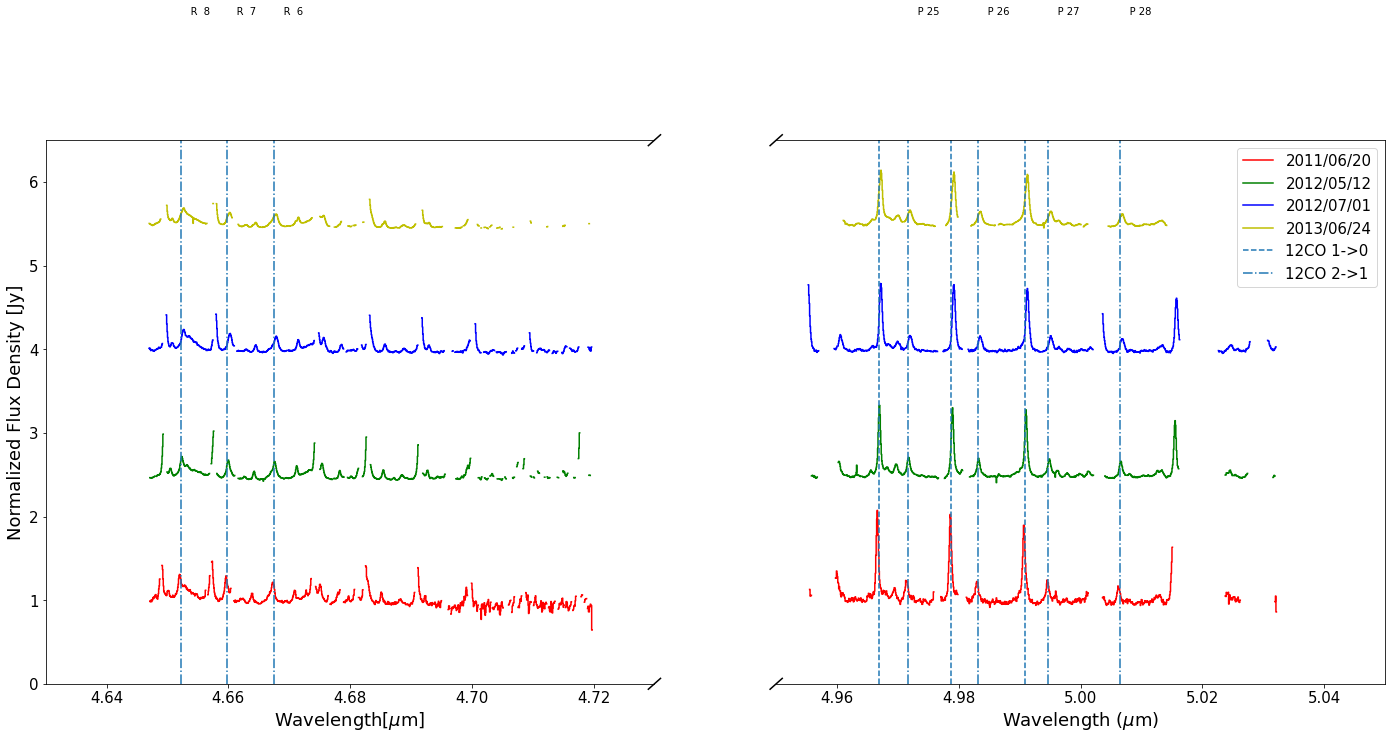

In [5]:
#######################################################################

# Preparing plot

fig=plt.figure(figsize=(24,10))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

#######################################################################

# Plotting data

ax1.plot(data20110620['wave'], data20110620['div'], drawstyle='steps-mid', color='r')
ax1.plot(data20120512['wave'], data20120512['div']+1.5, drawstyle='steps-mid', color='g')
ax1.plot(data20120701['wave'], data20120701['div']+3, drawstyle='steps-mid', color='b')
ax1.plot(data20130624['wave'], data20130624['div']+4.5, drawstyle='steps-mid', color='y')

ax2.plot(data20110620['wave'], data20110620['div'], drawstyle='steps-mid', color='r', label='2011/06/20')
ax2.plot(data20120512['wave'], data20120512['div']+1.5, drawstyle='steps-mid', color='g', label='2012/05/12')
ax2.plot(data20120701['wave'], data20120701['div']+3, drawstyle='steps-mid', color='b', label='2012/07/01')
ax2.plot(data20130624['wave'], data20130624['div']+4.5, drawstyle='steps-mid', color='y', label='2013/06/24')

#######################################################################

# Plotting CO Emission Lines

for i, wave in enumerate(hitran12CO1_0['wave']):
    if(wave<4.8):
        ax1.axvline(wave, 0,30, linestyle='--')
        #ax1.text(wave-0.001, 8, i)
    else:
        ax2.axvline(wave, 0,30, linestyle='--')
        #ax2.text(wave-0.001, 8, hitran12CO1_0['Qpp'][i])
    
for i, wave in enumerate(hitran12CO2_1['wave']):
    if(wave<4.8):
        ax1.axvline(wave, 0,30, linestyle='-.')
        ax1.text(wave-0.001, 8, hitran12CO2_1['Qpp'][i])
    else:
        ax2.axvline(wave, 0,30, linestyle='-.')
        ax2.text(wave-0.001, 8, hitran12CO2_1['Qpp'][i])
        
# Labeling Emission Lines
        
ax2.axvline(0,0,0, linestyle='--', label='12CO 1->0')
ax2.axvline(0,0,0, linestyle='-.', label='12CO 2->1')
    
#######################################################################

# Configuration of split x axis

# Tick marks signifying broken axis
g = .01
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-g,1+g), (-g,+g), **kwargs)
ax1.plot((1-g,1+g),(1-g,1+g), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-g,+g), (1-g,1+g), **kwargs)
ax2.plot((-g,+g), (-g,+g), **kwargs)

# Hiding axes and values on those axes
ax2.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.yaxis.set_visible(False)
#######################################################################

# Plot Formatting
ax1.set_xlabel('Wavelength[$\mu$m]', fontsize=18)
ax2.set_xlabel('Wavelength ($\mu$m)', fontsize=18)
ax1.set_ylabel('Normalized Flux Density [Jy]', fontsize=18)
ax2.legend(loc=1, prop={'size': 15})
ax1.set_xlim(4.63, 4.73)
ax2.set_xlim(4.95, 5.05)
ax1.set_ylim(0,6.5)
ax2.set_ylim(0,6.5)
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax2.tick_params(axis='x', labelsize=15 )


In [6]:
def graph_emission_line(hitranData, observations, dates, src, fitLines=True, km=False):
    
    fig=plt.figure(figsize(10,5))
    ax=fig.add_subplot(111)
    
    def waveToKM(myLambda, DLambda):
        vel = DLambda*const.c.to('km/s').value/ myLambda
        return vel
    
#######################################################################

    # For each date of observations, graph emission line
    for i in arange(dates.size):
        myBool = (observations[i]['wave'] > hitranData['wave']-0.001) & (observations[i]['wave'] < hitranData['wave']+0.001)
        wave=observations[i]['wave'][myBool]
        div=observations[i]['div'][myBool]
        k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])
        
#######################################################################

        # Plotting with x-axis in km/s
        if km:
            ax.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
            ax.set_xlabel('km/s', fontsize=12)
            axvline(0, 0,2, linestyle='--')
            
#######################################################################

            # fitLines will plot a line fit, and illustrate FWHM on emission line profile
            if fitLines:
                fit = line_fit(wave, div, nterms=4, p0=[0.1, hitranData['wave'], fwhm_to_sigma(20*1e3/const.c.value*hitranData['wave']), 1])
                ax.plot(k_m, fit['yfit'], label=dates[i]+' Fit')
                waveMax = k_m[np.argmax(fit['yfit'])]
                (fwhm, fwhm_err) = calc_linewidth(fit['parameters'], fit['parameter_errors'])
                x=arange(waveMax-fwhm.value/2, waveMax+fwhm.value/2, 0.1)
                ax.plot(x, np.full(x.size, np.max(fit['yfit'])-(np.max(fit['yfit'])-fit['parameters'][3])/2), label=dates[i]+' FWHM')
                
#######################################################################

        # Plotting with wavelength on x-axis
        else:
            ax.plot(wave,div,drawstyle='steps-mid', label=dates[i])
            ax.set_xlim(hitranData['wave']-0.001, hitranData['wave']+0.001)
            ax.set_xlabel('Wavelength [$\mu$m]', fontsize=12)
            axvline(hitranData['wave'], 0, 2, linestyle='--')
            if fitLines:
                fit = line_fit(wave, div, nterms=4, p0=[0.1, hitranData['wave'], fwhm_to_sigma(20*1e3/const.c.value*hitranData['wave']), 1])
                ax.plot(wave, fit['yfit'], label=dates[i]+' Fit')
                
#######################################################################
        
    # Plotting hitran emisssion line
    ax.axvline(0,0,0,linestyle='--', label=hitranData['Qpp'])
    
    if(hitranData['local_iso_id']==1):
        isotope = '12CO'
    elif(hitranData['local_iso_id']==2):
        isotope = '13CO'
        
    if(np.int(hitranData['Vp'])==1):
        trans= 'v=1-0'
    elif(np.int(hitranData['Vp'])==2):
        trans= 'v=2-1'
        
    pNum = hitranData['Qpp']
    title = 'Lineprofile for '+isotope+' '+trans+pNum+' Emission line from '+src
    
    # Setting title and axes labels
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Normalized Flux Density [Jy]', fontsize=12)
    ax.legend()
    
    

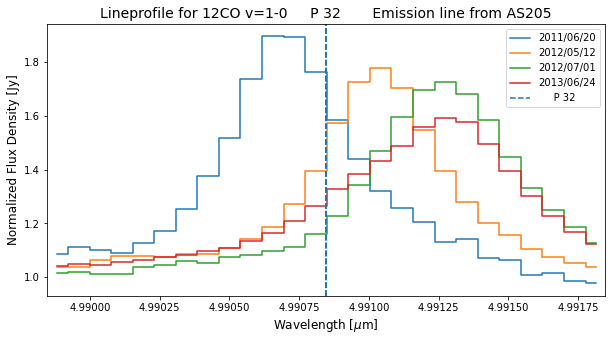

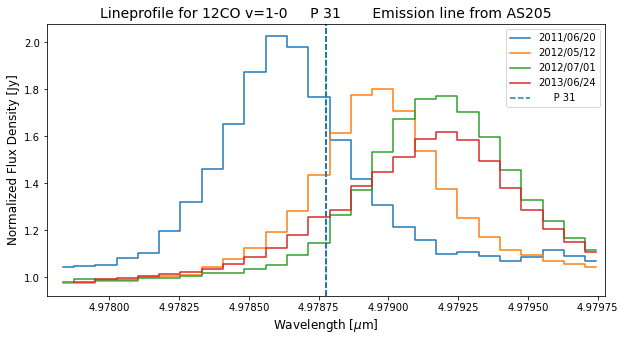

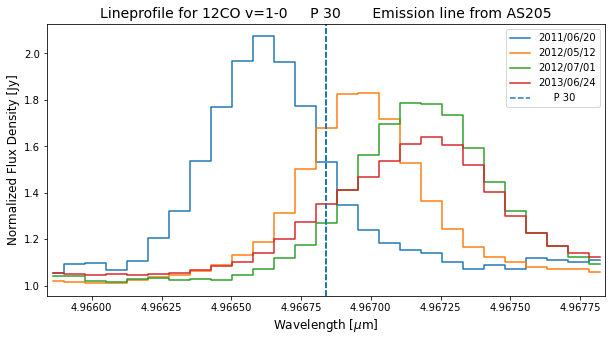

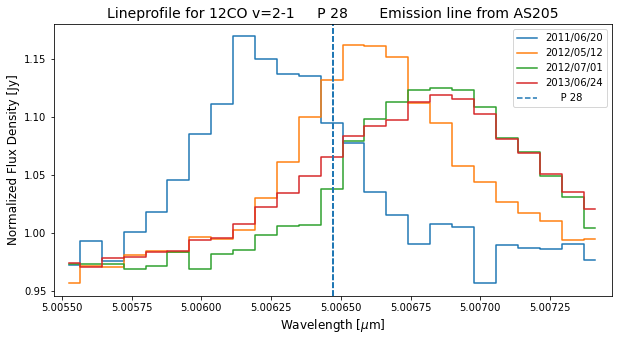

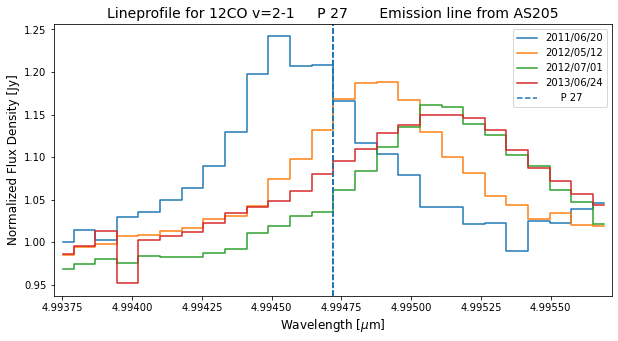

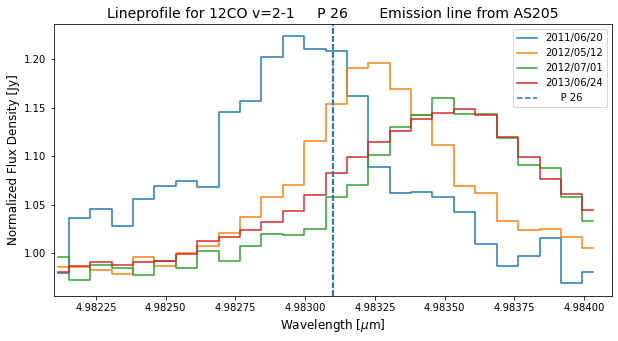

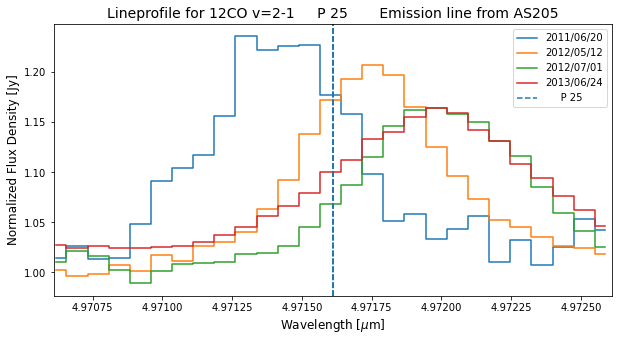

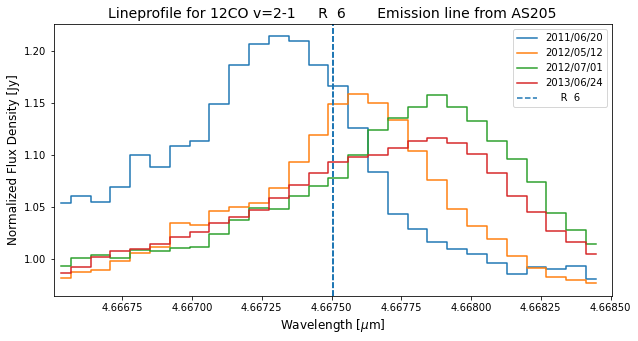

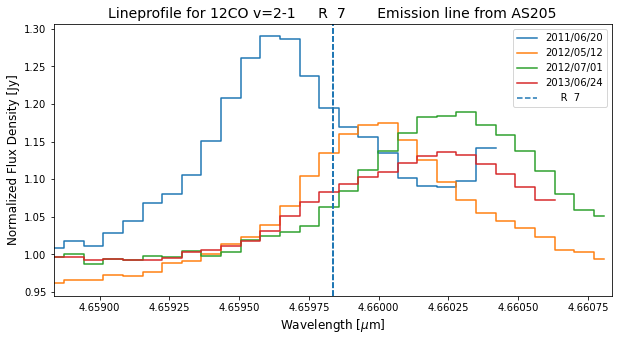

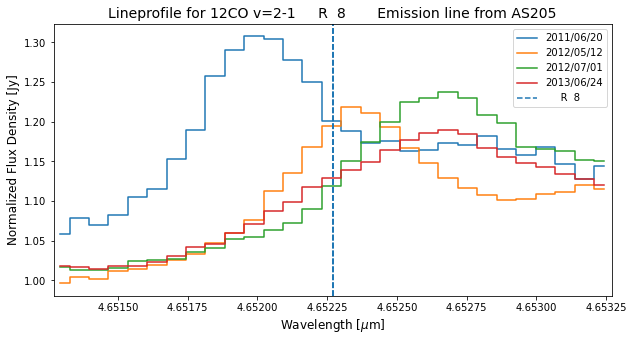

In [7]:
observations = np.array([data20110620,data20120512,data20120701,data20130624])
dates = np.array(['2011/06/20','2012/05/12','2012/07/01','2013/06/24'])

for i in arange(hitran12CO1_0['wave'].size):
    graph_emission_line(hitran12CO1_0[i], observations, dates, 'AS205', fitLines=False)
    
for i in arange(hitran12CO2_1['wave'].size):
    graph_emission_line(hitran12CO2_1[i], observations, dates, 'AS205', fitLines=False)
    

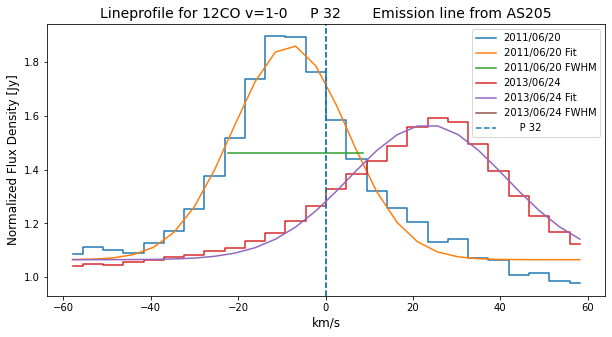

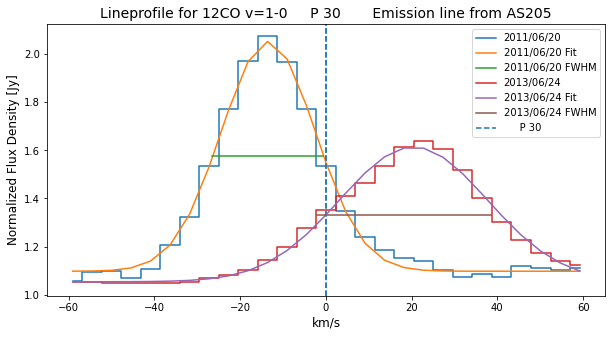

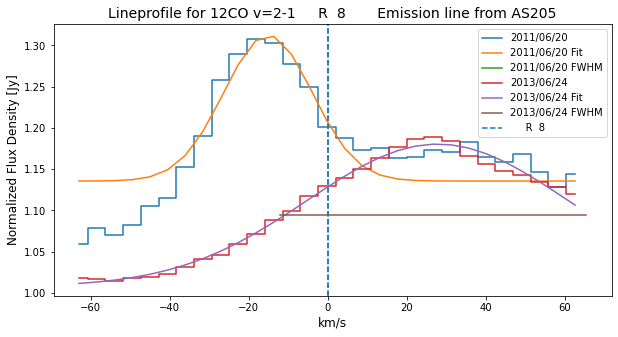

In [8]:
observations = np.array([data20110620, data20130624])
dates = np.array(['2011/06/20', '2013/06/24'])

graph_emission_line(hitran12CO1_0[0], observations, dates,'AS205', km=True)
graph_emission_line(hitran12CO1_0[2], observations, dates,'AS205', km=True)
graph_emission_line(hitran12CO2_1[6], observations, dates,'AS205', km=True)

In [9]:
t1=calc_fluxes(data20110620['wave'],data20110620['div'],hitran12CO1_0)
t2=calc_fluxes(data20120512['wave'],data20120512['div'],hitran12CO1_0)
t3=calc_fluxes(data20120701['wave'],data20120701['div'],hitran12CO1_0)
t4=calc_fluxes(data20130624['wave'],data20130624['div'],hitran12CO1_0)

t5=calc_fluxes(data20110620['wave'],data20110620['div'],hitran12CO2_1)
t6=calc_fluxes(data20120512['wave'],data20120512['div'],hitran12CO2_1)
t7=calc_fluxes(data20120701['wave'],data20120701['div'],hitran12CO2_1)
t8=calc_fluxes(data20130624['wave'],data20130624['div'],hitran12CO2_1)

# Linefluxes 
## 2011/06 shifted -0.0009, 2012/05 shifted -0.0003, 2012/07 shifted +0.0003, 2013/06 shifted +0.0009

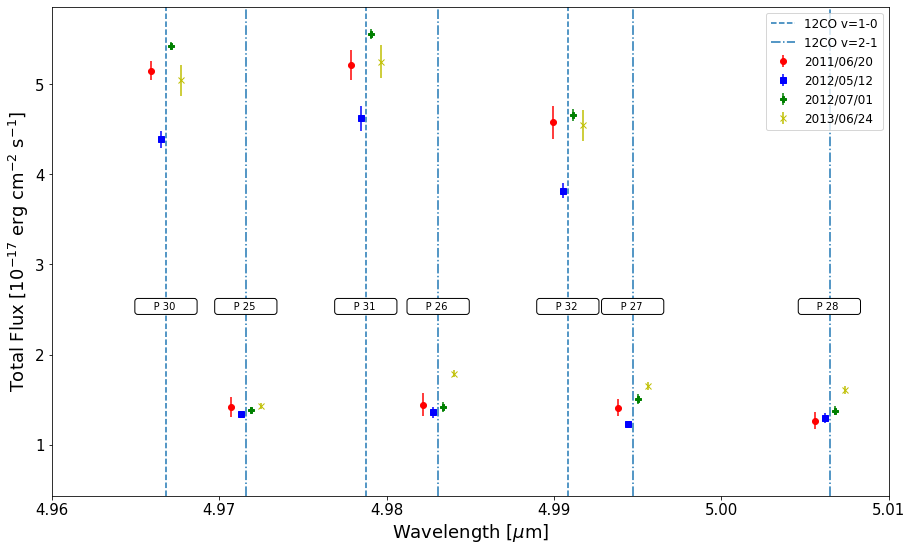

In [10]:
#######################################################################

# Configuring Plot

fig=plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111)

#######################################################################

# Configuring text box

props = dict(boxstyle='round', facecolor='white', alpha=1)

# Drawing and labeling CO emission lines

for i, wave in enumerate(hitran12CO1_0['wave']):
    ax1.axvline(wave, 0, 30, linestyle='--')
    ax1.text(wave-0.0017, 2.5, hitran12CO1_0['Qpp'][i], bbox=props)
    
for i, wave in enumerate(hitran12CO2_1['wave']):
    if (wave>4.9):
        ax1.axvline(wave, 0, 30, linestyle='-.')
        ax1.text(wave-0.0017, 2.5, hitran12CO2_1['Qpp'][i],bbox=props)
        
# Labeling Hitran Data
        
ax1.axvline(0,0,0, linestyle='--', label='12CO v=1-0')
ax1.axvline(0,0,0, linestyle='-.', label='12CO v=2-1')

#######################################################################

# Plotting Linefluxes and error bars for each date

errorbar(t1['wave']-0.0009, t1['lineflux']*1e17, yerr=t1['lineflux_err']*1e17, fmt='ro', label='2011/06/20')
errorbar(t2['wave']-0.0003, t2['lineflux']*1e17, yerr=t2['lineflux_err']*1e17, fmt='bs', label='2012/05/12')
errorbar(t3['wave']+0.0003, t3['lineflux']*1e17, yerr=t3['lineflux_err']*1e17, fmt='gP', label='2012/07/01')
errorbar(t4['wave']+0.0009, t4['lineflux']*1e17, yerr=t4['lineflux_err']*1e17, fmt='yx', label='2013/06/24')
errorbar(t5['wave']-0.0009, t5['lineflux']*1e17, yerr=t5['lineflux_err']*1e17, fmt='ro')
errorbar(t6['wave']-0.0003, t6['lineflux']*1e17, yerr=t6['lineflux_err']*1e17, fmt='bs')
errorbar(t7['wave']+0.0003, t7['lineflux']*1e17, yerr=t7['lineflux_err']*1e17, fmt='gP')
errorbar(t8['wave']+0.0009, t8['lineflux']*1e17, yerr=t8['lineflux_err']*1e17, fmt='yx')

#######################################################################

# Plot Formatting

ax1.set_ylabel('Total Flux [10$^{-17}$ erg cm$^{-2}$ s$^{-1}$]', fontsize=18)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
ax1.set_xlim(4.96, 5.01)
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax1.legend(loc=1, prop={'size': 12})

In all of these higher energy emission lines, with P 26 and P 28 12CO v=2-1 lines, 2011/06/20 lines had the highest total flux, then 2012/07/01 data, then 2012/05/12 data, and finally 2013/06/24 data with lowest total flux.

In [11]:
np.mean((t1['lineflux']-t4['lineflux'])/t1['lineflux']*100)

0.6730814632430074

# Linewidth

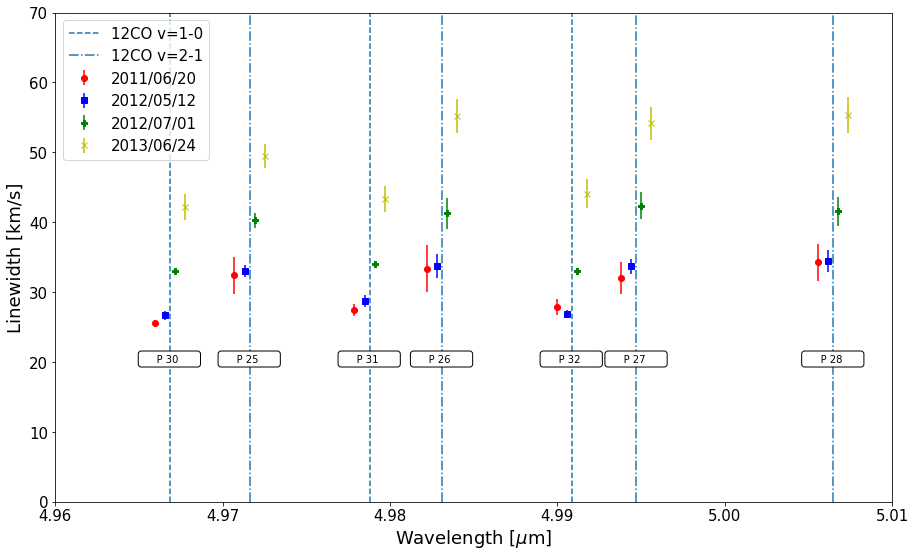

In [12]:
fig=plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111)

props = dict(boxstyle='round', facecolor='white', alpha=1)

for i, wave in enumerate(hitran12CO1_0['wave']):
    ax1.axvline(wave, 0, 30, linestyle='--')
    ax1.text(wave-0.0017, 20, hitran12CO1_0['Qpp'][i], bbox=props)
    
for i, wave in enumerate(hitran12CO2_1['wave']):
    if (wave>4.9):
        ax1.axvline(wave, 0, 30, linestyle='-.')
        ax1.text(wave-0.0017, 20, hitran12CO2_1['Qpp'][i],bbox=props)
        
        
ax1.axvline(0,0,0, linestyle='--', label='12CO v=1-0')
ax1.axvline(0,0,0, linestyle='-.', label='12CO v=2-1')

errorbar(t1['wave']-0.0009, t1['linewidth'], yerr=t1['linewidth_err'], fmt='ro', label='2011/06/20')
errorbar(t2['wave']-0.0003, t2['linewidth'], yerr=t2['linewidth_err'], fmt='bs', label='2012/05/12')
errorbar(t3['wave']+0.0003, t3['linewidth'], yerr=t3['linewidth_err'], fmt='gP', label='2012/07/01')
errorbar(t4['wave']+0.0009, t4['linewidth'], yerr=t4['linewidth_err'], fmt='yx', label='2013/06/24')
errorbar(t5['wave']-0.0009, t5['linewidth'], yerr=t5['linewidth_err'], fmt='ro')
errorbar(t6['wave']-0.0003, t6['linewidth'], yerr=t6['linewidth_err'], fmt='bs')
errorbar(t7['wave']+0.0003, t7['linewidth'], yerr=t7['linewidth_err'], fmt='gP')
errorbar(t8['wave']+0.0009, t8['linewidth'], yerr=t8['linewidth_err'], fmt='yx')


ax1.set_ylabel('Linewidth [km/s]', fontsize=18)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=18)

ax1.set_xlim(4.96, 5.01)

ax1.set_ylim(0,70)
ax1.legend(loc=2, prop={'size': 15})
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )

#fig.savefig("./Plots/linewidth")

In these higher energy emission lines, 2011/06/20 and 2012/05/12 had the smallest linewidth, and then 2012/07/01 had the next largest, and then 2013/06/24 with the largest linewidth.

# Orbital Distances

Using Kepler's Third Law

$T^2 = \frac{4 \pi^2}{GM_{\star}}a^3$

$T = \frac{2\pi}{\omega}$, $\omega = \frac{(v/cos(i))^2}{a}$

$\frac{4\pi^2 a^2}{(v/cos(i))^2} = \frac{4\pi^2}{GM_{\star}}a^3$

$a = \frac{GM_{\star}cos^2(i)}{v^2}$

FWHM shows the gas's radial speed on either side of it's orbit due to doppler broadening, so dividing by 2 will yield the radial speed of the gas in orbit. I'll average from each of the dates the FWHM from the linewidths of viable 12CO v=1-0 and 12CO v=2-1 emission lines.

In [13]:
inclination = 15*pi/180 # inclination of 15 deg according to Salyk et al. 2014
mStar = 1 # best fit mass of AS205 N from Salyk et al. 2014

t1t5 = np.append(t1['linewidth'], t5['linewidth'])
t1t5_err = np.append(t1['linewidth_err'], t5['linewidth_err'])

t2t6 = np.append(t2['linewidth'], t6['linewidth'])
t2t6_err = np.append(t2['linewidth_err'], t6['linewidth_err'])

t3t7 = np.append(t3['linewidth'], t7['linewidth'])
t3t7_err = np.append(t3['linewidth_err'], t7['linewidth_err'])

t4t8 = np.append(t4['linewidth'], t8['linewidth'])
t4t8_err = np.append(t4['linewidth_err'], t8['linewidth_err'])

#######################################################################

# Finding averaged linewidths and error for each date

ave20110620 = np.mean(t1t5)
ave_err_20110620 = sqrt(np.sum(t1t5_err**2))/t1t5_err.size

ave20120512 = np.mean(t2t6)
ave_err_20120512 = sqrt(np.sum(t2t6_err**2))/t2t6_err.size

ave20120701 = np.mean(t3t7)
ave_err_20120701 = sqrt(np.sum(t3t7_err**2))/t3t7_err.size

ave20130624 = np.mean(t4t8)
ave_err_20130624 = sqrt(np.sum(t4t8_err**2))/t4t8_err.size

#######################################################################

def find_orbital_dist(speed):

    # mStar in solar masses
    # speed in km/s
    
    a = const.G.value*mStar*const.M_sun.value*cos(inclination)**2/(speed/2*1000)**2
    return a*u.m.to(u.AU)

def find_linewidth(dist):
    v = sqrt(const.G.value*mStar*const.M_sun.value*cos(inclination)**2/(1000**2*dist*u.AU.to(u.m)))
    return v*2

def find_orbital_dist_err(speed, speed_err):
    sigma = (2*const.G.value*mStar*const.M_sun.value*(cos(inclination)**3)/(((speed/2)*1000)**3))*(speed_err/2)
    return sigma*u.m.to(u.AU)

#######################################################################

dist20110620 = find_orbital_dist(ave20110620)
dist_err_20110620 = find_orbital_dist_err(ave20110620, ave_err_20110620)

dist20120512 = find_orbital_dist(ave20120512)
dist_err_20120512 = find_orbital_dist_err(ave20120512, ave_err_20120512)

dist20120701 = find_orbital_dist(ave20120701)
dist_err_20120701 = find_orbital_dist_err(ave20120701, ave_err_20120701)

dist20130624 = find_orbital_dist(ave20130624)
dist_err_20130624 = find_orbital_dist_err(ave20130624, ave_err_20130624)

print(dist20110620*u.AU, "+/-", dist_err_20110620*u.AU)
print(dist20120512*u.AU, "+/-", dist_err_20120512*u.AU)
print(dist20120701*u.AU, "+/-", dist_err_20120701*u.AU)
print(dist20130624*u.AU, "+/-", dist_err_20130624*u.AU)

3.6583602578739947 AU +/- 0.0001591986911033898 AU
3.0461165055148878 AU +/- 9.647879389541839e-05 AU
1.9946202265571542 AU +/- 5.4529404564635914e-05 AU
1.126788302814022 AU +/- 3.901646256384997e-05 AU


In [14]:
print(find_orbital_dist(50.3))
print(find_linewidth(2))
const.G

1.308572530584017
40.6866456832295


<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


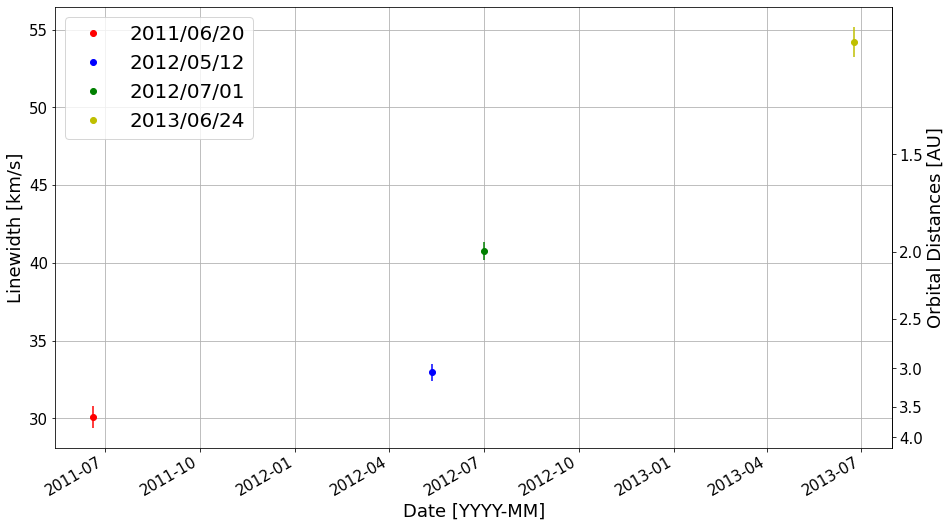

In [15]:
#######################################################################

fig=plt.figure(figsize=(15,9))
ax=fig.add_subplot(111)
#ax1 = ax.twinx()

#######################################################################


ax.plot_date(mydate20110620.plot_date, ave20110620, color='r', label='2011/06/20')
ax.plot_date(mydate20120512.plot_date, ave20120512, color='b', label='2012/05/12')
ax.plot_date(mydate20120701.plot_date, ave20120701, color='g', label='2012/07/01')
ax.plot_date(mydate20130624.plot_date, ave20130624, color='y', label='2013/06/24')

errorbar(mydate20110620.plot_date, ave20110620, yerr=ave_err_20110620, color='r')
errorbar(mydate20120512.plot_date, ave20120512, yerr=ave_err_20120512, color='b')
errorbar(mydate20120701.plot_date, ave20120701, yerr=ave_err_20120701, color='g')
errorbar(mydate20130624.plot_date, ave20130624, yerr=ave_err_20130624, color='y')


#ax.errorbar(mydate20110620.plot_date, dist20110620.value, yerr=dist_err_20110620.value)
#ax.errorbar(mydate20120512.plot_date, dist20120512.value, yerr=dist_err_20120512.value)
#ax.errorbar(mydate20120701.plot_date, dist20120701.value, yerr=dist_err_20120701.value)
#ax.errorbar(mydate20130624.plot_date, dist20130624.value, yerr=dist_err_20130624.value)

secaxy = ax.secondary_yaxis('right', functions=(find_orbital_dist, find_linewidth))
secaxy.set_ylabel('Orbital Distances [AU]', fontsize=18)


#######################################################################

ax.set_xlabel('Date [YYYY-MM]', fontsize=18)
ax.set_ylabel('Linewidth [km/s]', fontsize=18)
ax.legend(prop={'size': 20})
ax.tick_params(axis='x', labelsize=15 )
ax.tick_params(axis='y', labelsize=15 )
secaxy.tick_params(axis='y', labelsize=15)
fig.autofmt_xdate()

ax.grid()

fig.savefig('./Plots/AS205orbit')


# Viscosity Calculation

$\nu = \alpha c_s H$

$c_s = \sqrt{\frac{\gamma k T}{m}}$

$H = \frac{c_s}{\Omega}$

$\nu = \alpha \frac{c_s^2}{\Omega}$

Taking T to be the equilibrium temperature at 1.31 AU (the closest recorded orbital distance) to result in lowest $\alpha$ value. Albedo=0.

$T_{eq} = T_{\star}\sqrt{\frac{R_{\star}}{2D}}$

Since AS205 N is 1M$_{\odot}$, I'm taking $T_{\star} = T_{\odot}$, $R_{\star}=R_{\odot}$

$T_{eq} = T_{\odot} \sqrt{\frac{R_{\odot}}{2*1.31AU}}$

$T_{eq} = 343.9 K$

$\gamma=1.4$ for diatomic molecules

$c_s = \sqrt{\frac{1.4*k*343.9K}{28.011 kg/kmol * 1kmol/6.022*10^{26}}}$

$c_s = 378 m/s$

$\Omega = \sqrt{\frac{GM_{\star}}{a^3}}$

$\Omega = \sqrt{\frac{GM_{\odot}}{(1.31 AU)^3}} = 26023 Hz$

$\tau_{\nu} = \frac{R^2}{\nu}$

$\nu = 1.84*10^{16}$

$1.84*10^{16} = \alpha \frac{(378m/s)^2}{26023 Hz}$

$\alpha = 3.35*10^{15}$

In [16]:
time = 50*u.d.to(u.s)

delta_a = (dist20120512-dist20120701)*u.AU.to(u.m)

viscosity = delta_a**2/time

omega = sqrt(const.G.value*const.M_sun.value/(1.31*u.AU.to(u.m)))

sound = sqrt(1.4*const.k_B.value*343.9/(28.011/6.022e26))

alpha = viscosity * 26023 / (378**2)

print(alpha/1e15)

1.043172956120457


# Change in Inclination

/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


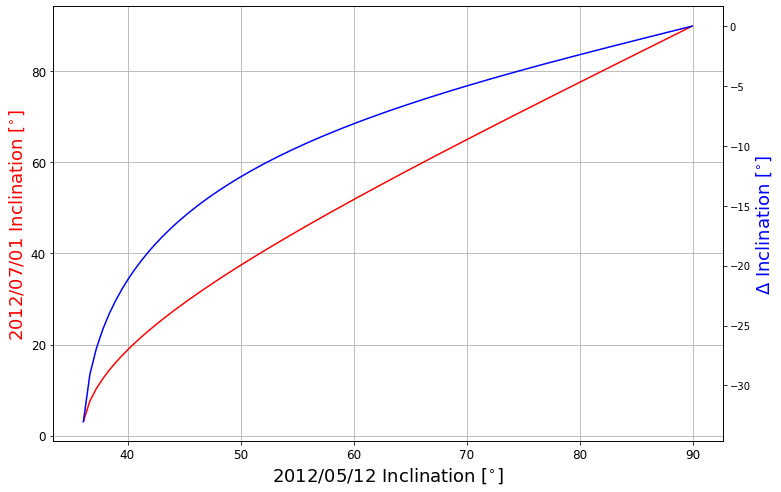

In [17]:
math.acos(1/((ave20120701/2)/(cos(15*pi/180)*(ave20110620/2))))*180/pi

#######################################################################

fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)

#######################################################################

inclination20120512 = np.arange(0, pi/2, 0.01)

inclination20120701 = np.arccos(ave20120701*cos(inclination20120512)/(ave20120512))

ax.plot(inclination20120512*180/pi, inclination20120701*180/pi, color='r')

#######################################################################

ax1 = ax.twinx()

ax1.plot(inclination20120512*180/pi, inclination20120701*180/pi-inclination20120512*180/pi, color='b')

#######################################################################

ax.set_xlabel('2012/05/12 Inclination [$^{\circ}$]', fontsize=18)
ax.set_ylabel('2012/07/01 Inclination [$^{\circ}$]', fontsize=18, color='r')
ax1.set_ylabel('$\Delta$ Inclination [$^{\circ}$]', fontsize=18, color='b')
ax.tick_params(labelsize=12)
ax.grid()
#ax.set_xlim(0, 90)
#ax.set_ylim(0,90)

#fig.savefig('./Plots/AS205Inclination')


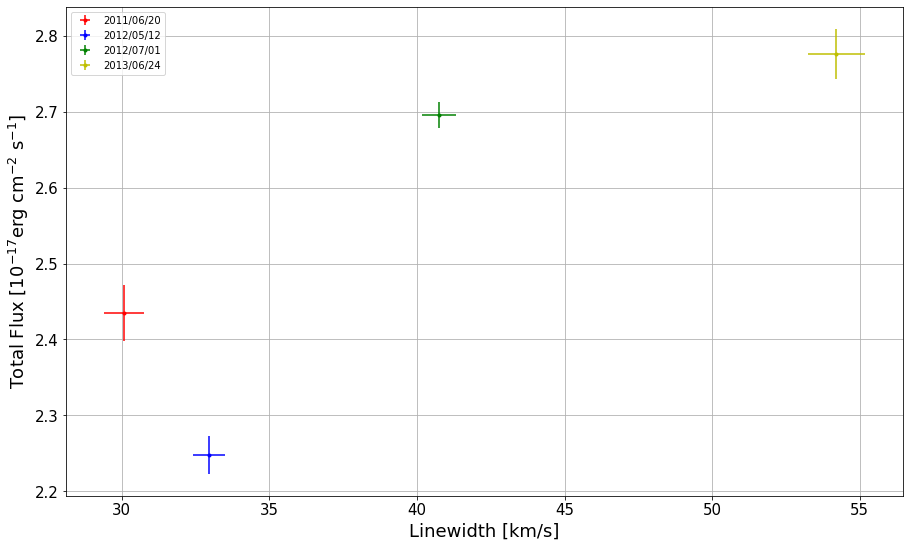

In [18]:
#######################################################################

fig=plt.figure(figsize=(15,9))
ax=fig.add_subplot(111)

#######################################################################

flux_mean20110620 = np.mean(np.append(t1['lineflux'], t5['lineflux']))*1e17
flux_mean_err_20110620 = sqrt(np.sum(np.append(t1['lineflux_err'], t5['lineflux_err'])**2))/(t1['lineflux_err'].size+t5['lineflux_err'].size)

flux_mean20120512 = np.mean(np.append(t2['lineflux'], t6['lineflux']))*1e17
flux_mean_err_20120512 = sqrt(np.sum(np.append(t2['lineflux_err'], t6['lineflux_err'])**2))/(t2['lineflux_err'].size+t6['lineflux_err'].size)

flux_mean20120701 = np.mean(np.append(t3['lineflux'], t7['lineflux']))*1e17
flux_mean_err_20120701 = sqrt(np.sum(np.append(t3['lineflux_err'], t7['lineflux_err'])**2))/(t3['lineflux_err'].size+t7['lineflux_err'].size)

flux_mean20130624 = np.mean(np.append(t4['lineflux'], t8['lineflux']))*1e17
flux_mean_err_20130624 = sqrt(np.sum(np.append(t4['lineflux_err'], t8['lineflux_err'])**2))/(t4['lineflux_err'].size+t8['lineflux_err'].size)

#######################################################################

ax.errorbar(ave20110620, flux_mean20110620, xerr=ave_err_20110620, yerr=flux_mean_err_20110620*1e17, color='r', fmt='.', label='2011/06/20')
ax.errorbar(ave20120512, flux_mean20120512, xerr=ave_err_20120512, yerr=flux_mean_err_20120512*1e17, color='b', fmt='.', label='2012/05/12')
ax.errorbar(ave20120701, flux_mean20120701, xerr=ave_err_20120701, yerr=flux_mean_err_20120701*1e17, color='g', fmt='.', label='2012/07/01')
ax.errorbar(ave20130624, flux_mean20130624, xerr=ave_err_20130624, yerr=flux_mean_err_20130624*1e17, color='y', fmt='.', label='2013/06/24')

#######################################################################

ax.set_ylabel('Total Flux [10$^{-17}$erg cm$^{-2}$ s$^{-1}$]', fontsize=18)
ax.set_xlabel('Linewidth [km/s]', fontsize=18)
ax.legend()
ax.tick_params(axis='x', labelsize=15 )
ax.tick_params(axis='y', labelsize=15 )
ax.grid()



# Rotation Diagram

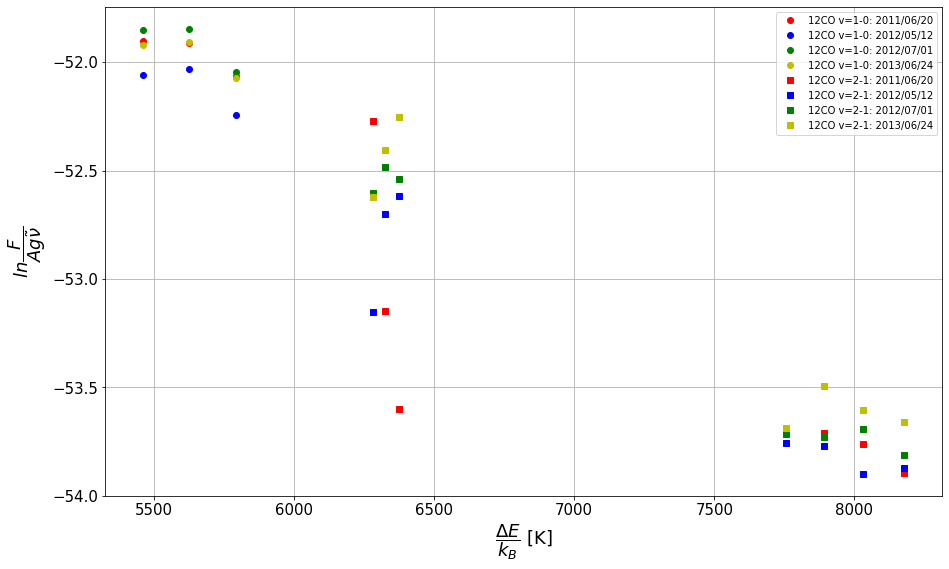

In [19]:
#######################################################################

# defining rotation diagram

graph1 = make_rotation_diagram(t1)
graph2 = make_rotation_diagram(t2)
graph3 = make_rotation_diagram(t3)
graph4 = make_rotation_diagram(t4)
graph5 = make_rotation_diagram(t5)
graph6 = make_rotation_diagram(t6)
graph7 = make_rotation_diagram(t7)
graph8 = make_rotation_diagram(t8)

#######################################################################

# Preparing plot

fig=plt.figure(figsize=(15,9))
ax1=fig.add_subplot(111)

# Plotting data

ax1.plot(graph1['x'], graph1['y'], 'ro', label='12CO v=1-0: 2011/06/20')
ax1.plot(graph2['x'], graph2['y'], 'bo', label='12CO v=1-0: 2012/05/12')
ax1.plot(graph3['x'], graph3['y'], 'go', label='12CO v=1-0: 2012/07/01')
ax1.plot(graph4['x'], graph4['y'], 'yo', label='12CO v=1-0: 2013/06/24')
ax1.plot(graph5['x'], graph5['y'], 'rs', label='12CO v=2-1: 2011/06/20')
ax1.plot(graph6['x'], graph6['y'], 'bs', label='12CO v=2-1: 2012/05/12')
ax1.plot(graph7['x'], graph7['y'], 'gs', label='12CO v=2-1: 2012/07/01')
ax1.plot(graph8['x'], graph8['y'], 'ys', label='12CO v=2-1: 2013/06/24')

# Configuring plot

ax1.set_ylabel('$ln\\dfrac{F}{Ag\~\\nu}$', fontsize=18)
ax1.set_xlabel('$\\dfrac{\Delta E}{k_B}$ [K]', fontsize=18)
ax1.legend(loc=1,prop={'size': 10})
ax1.grid()
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )

#######################################################################

# Plotting fit

fit20110620x = np.append(graph1['x'], graph5['x'][:4])
fit20110620y = np.append(graph1['y'], graph5['y'][:4])

fit20120512x = np.append(graph2['x'], graph6['x'][:4])
fit20120512y = np.append(graph2['y'], graph6['y'][:4])

fit20120701x = np.append(graph3['x'], graph6['x'][:4])
fit20120701y = np.append(graph3['y'], graph6['y'][:4])

fit20130624x = np.append(graph4['x'], graph6['x'][:4])
fit20130624y = np.append(graph4['y'], graph6['y'][:4])

m1, b1 = np.polyfit(fit20110620x, fit20110620y, 1)
m2, b2 = np.polyfit(fit20120512x, fit20120512y, 1)
m3, b3 = np.polyfit(fit20120701x, fit20120701y, 1)
m4, b4 = np.polyfit(fit20130624x, fit20130624y, 1)

#ax1.plot(fit20110620x, m1*fit20110620x+b1, color='r')
#ax1.plot(fit20120512x, m2*fit20120512x+b2, color='b')
#ax1.plot(fit20120701x, m3*fit20120701x+b3, color='g')
#ax1.plot(fit20130624x, m4*fit20130624x+b4, color='y')

fig.savefig('./Plots/rotation')



/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  import sys
/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  
/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; pleas

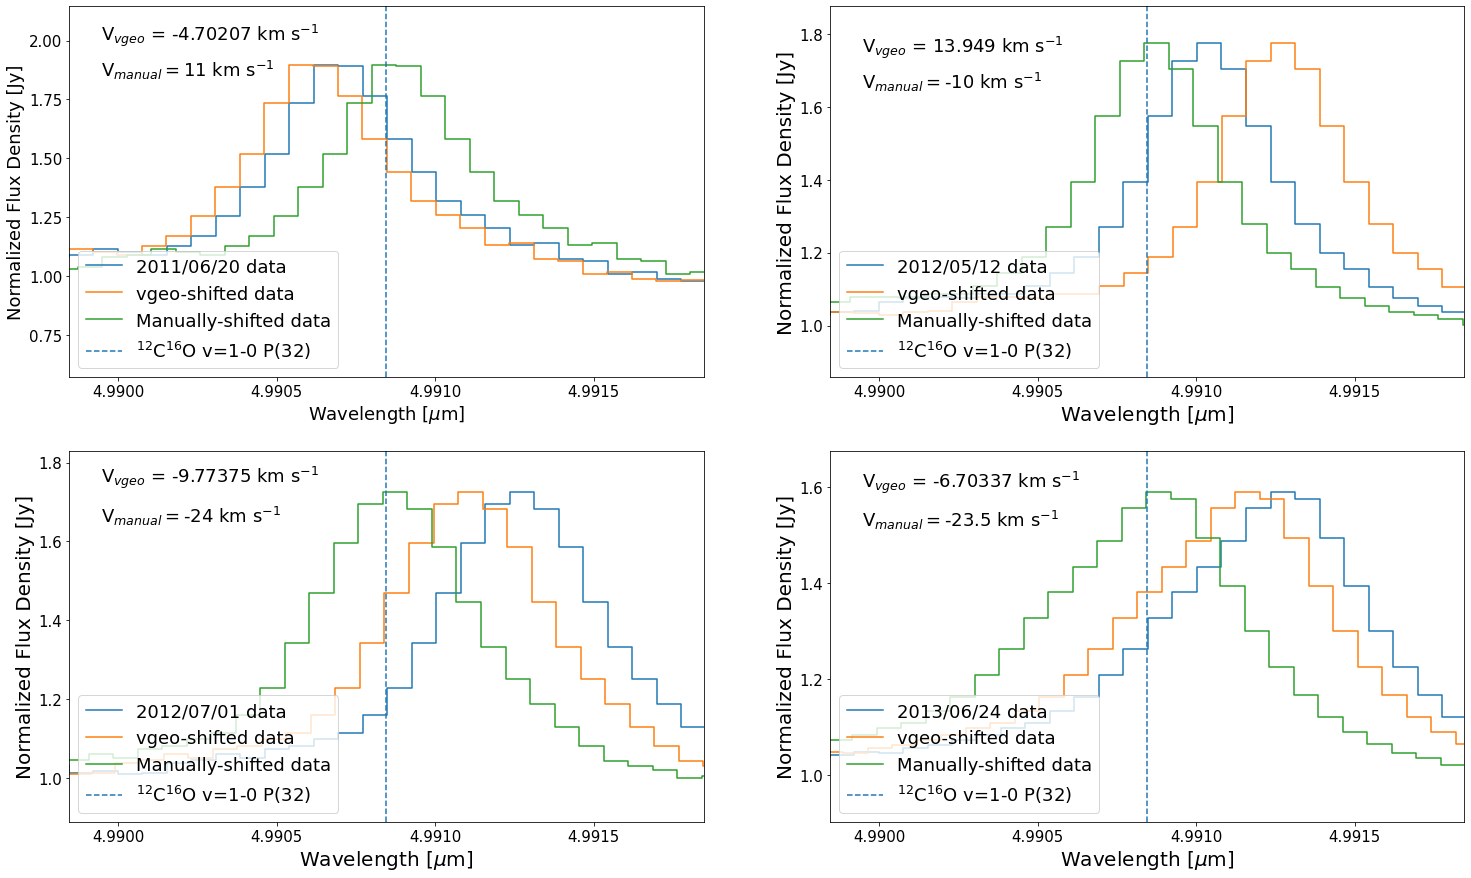

In [27]:
fig=plt.figure(figsize(25,15))
ax=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

ax.plot(data20110620['wave'], data20110620['div'], linestyle='steps-mid', label='2011/06/20 data')
ax.plot(vgeo20110620, data20110620['div'],linestyle='steps-mid', label='vgeo-shifted data')
ax.plot(a, data20110620['div'], linestyle='steps-mid', label='Manually-shifted data')
ax.axvline(hitran12CO1_0['wave'][0], linestyle='--', label='$^{12}$C$^{16}$O v=1-0 P(32)')

string = "V$_{vgeo}$ = " + str(round(-vgeo(mydate20110620,mycoord,vhel=vhelio), 5)) + ' km s$^{-1}$'
ax.text(hitran12CO1_0['wave'][0]-0.0009,2, string, fontsize=18)
string1 = 'V$_{manual} = $' +str(vdop20110620) + ' km s$^{-1}$'
ax.text(hitran12CO1_0['wave'][0]-0.0009,1.85, string1, fontsize=18)

ax.set_xlim(hitran12CO1_0['wave'][0]-0.001, hitran12CO1_0['wave'][0]+0.001)
ax.legend(loc=3, prop={'size':18})
ax.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
ax.set_ylabel('Normalized Flux Density [Jy]', fontsize=18)
ax.tick_params(labelsize=11)

ax1.plot(data20120512['wave'], data20120512['div'], linestyle='steps-mid', label='2012/05/12 data')
ax1.plot(vgeo20120512, data20120512['div'],linestyle='steps-mid', label='vgeo-shifted data')
ax1.plot(b, data20120512['div'], linestyle='steps-mid', label='Manually-shifted data')
ax1.axvline(hitran12CO1_0['wave'][0], linestyle='--', label='$^{12}$C$^{16}$O v=1-0 P(32)')

ax1.set_xlim(hitran12CO1_0['wave'][0]-0.001, hitran12CO1_0['wave'][0]+0.001)
ax1.legend(loc=3, prop={'size':18})
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=20)
ax1.set_ylabel('Normalized Flux Density [Jy]', fontsize=20)
ax1.tick_params(labelsize=11)

string = "V$_{vgeo}$ = " + str(round(-vgeo(mydate20120512,mycoord,vhel=vhelio), 5)) + ' km s$^{-1}$'
ax1.text(hitran12CO1_0['wave'][0]-0.0009,1.75, string, fontsize=18)
string1 = 'V$_{manual} = $' +str(vdop20120512) + ' km s$^{-1}$'
ax1.text(hitran12CO1_0['wave'][0]-0.0009,1.65, string1, fontsize=18)

ax2.plot(data20120701['wave'], data20120701['div'], linestyle='steps-mid', label='2012/07/01 data')
ax2.plot(vgeo20120701, data20120701['div'],linestyle='steps-mid', label='vgeo-shifted data')
ax2.plot(c, data20120701['div'], linestyle='steps-mid', label='Manually-shifted data')
ax2.axvline(hitran12CO1_0['wave'][0], linestyle='--', label='$^{12}$C$^{16}$O v=1-0 P(32)')

string = "V$_{vgeo}$ = " + str(round(-vgeo(mydate20120701,mycoord,vhel=vhelio), 5)) + ' km s$^{-1}$'
ax2.text(hitran12CO1_0['wave'][0]-0.0009,1.75, string, fontsize=18)
string1 = 'V$_{manual} = $' +str(vdop20120701) + ' km s$^{-1}$'
ax2.text(hitran12CO1_0['wave'][0]-0.0009,1.65, string1, fontsize=18)

ax2.set_xlim(hitran12CO1_0['wave'][0]-0.001, hitran12CO1_0['wave'][0]+0.001)
ax2.legend(loc=3, prop={'size':18})
ax2.set_xlabel('Wavelength [$\mu$m]', fontsize=20)
ax2.set_ylabel('Normalized Flux Density [Jy]', fontsize=20)
ax2.tick_params(labelsize=11)


ax3.plot(data20130624['wave'], data20130624['div'], linestyle='steps-mid', label='2013/06/24 data')
ax3.plot(vgeo20130624, data20130624['div'],linestyle='steps-mid', label='vgeo-shifted data')
ax3.plot(d, data20130624['div'], linestyle='steps-mid', label='Manually-shifted data')
ax3.axvline(hitran12CO1_0['wave'][0], linestyle='--', label='$^{12}$C$^{16}$O v=1-0 P(32)')

string = "V$_{vgeo}$ = " + str(round(-vgeo(mydate20130624,mycoord,vhel=vhelio), 5)) + ' km s$^{-1}$'
ax3.text(hitran12CO1_0['wave'][0]-0.0009,1.6, string, fontsize=18)
string1 = 'V$_{manual} = $' +str(vdop20130624) + ' km s$^{-1}$'
ax3.text(hitran12CO1_0['wave'][0]-0.0009,1.52, string1, fontsize=18)

ax3.set_xlim(hitran12CO1_0['wave'][0]-0.001, hitran12CO1_0['wave'][0]+0.001)
ax3.legend(loc=3, prop={'size':18})
ax3.set_xlabel('Wavelength [$\mu$m]', fontsize=20)
ax3.set_ylabel('Normalized Flux Density [Jy]', fontsize=20)
ax3.tick_params(labelsize=12)

ax.locator_params(nbins=7)
ax1.locator_params(nbins=7)
ax2.locator_params(nbins=7)
ax3.locator_params(nbins=7)

ax.tick_params(labelsize=15 )
ax1.tick_params(labelsize=15 )
ax2.tick_params(labelsize=15 )
ax3.tick_params(labelsize=15 )

fig.savefig('./Plots/AS205vgeoShift.eps')

